In [135]:
"""
Importing all packages
"""
import fasttext
import nltk
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import preprocess

In [136]:
"""
Read CSV
"""
refactorDf = pd.read_csv("../data/csvRefactorProject.csv")

In [137]:
"""
Remove unnecessary CSV columns
"""
refactorDf=refactorDf[['subject','description','Category']]

In [138]:
"""
Remove Nulls
"""
refactorDf = refactorDf.dropna()

In [139]:
"""
Description contains both subject and description,
so remove the subject portion from the description,
 making the columns not duplicating information
"""
refactorDf['description'] = refactorDf.apply(lambda row : row['description'].replace(str(row['subject']), ''), axis=1)


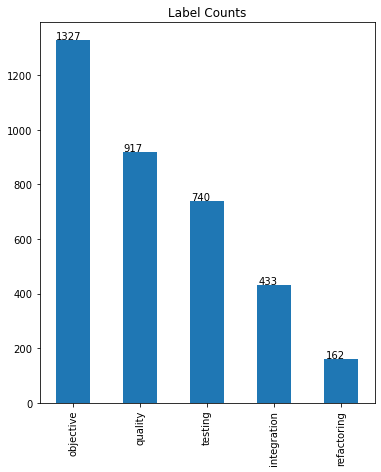

In [140]:
"""
Generate bar plots for how many label counts there are
"""
plot = refactorDf['Category'].value_counts().plot(kind='bar',
                                    figsize=(6,7),
                                    title="Label Counts")
for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
                                    

In [141]:
"""
Generate Output figures
"""
plot.get_figure().savefig('output/LabelCountBarPlot.pdf')

In [142]:
"""
Pivot category into new columns for each unique value, 
OHE labels essentially
"""
pivotDf = refactorDf.pivot_table(index = ['subject','description'],columns=["Category"],fill_value=0,aggfunc=len)
pivotDf=pivotDf.reset_index()

In [143]:
"""
Check Columns
"""
pivotDf.columns

Index(['subject', 'description', 'integration', 'objective', 'quality',
       'refactoring', 'testing'],
      dtype='object', name='Category')

In [144]:
"""
Generate count of associated labels per unique subject description combo
"""
pivotDf['categoryCount']=pivotDf['integration']+pivotDf['objective']+pivotDf['quality']+pivotDf['refactoring']+pivotDf['testing']

In [145]:
"""
Find counts of how many unique entries have X counts of labels associated
"""

oneCat = pivotDf.query("categoryCount == 1")
twoCat = pivotDf.query("categoryCount == 2")
threeCat = pivotDf.query("categoryCount == 3")
fourCat = pivotDf.query("categoryCount == 4")
fiveCat = pivotDf.query("categoryCount == 5")

In [146]:
"""
Output gen for distribution of label counts
"""
print("One category: "+str(oneCat.shape[0])+"\n"+"Two category: "
+str(twoCat.shape[0])+'\n'+"Three cat: "+str(threeCat.shape[0])+'\n'
+"Four cat: "+str(fourCat.shape[0])+'\n'+
"Five cat: "+str(fiveCat.shape[0]))

One category: 348
Two category: 882
Three cat: 437
Four cat: 39
Five cat: 0


In [147]:
"""
Generate DF for visual of category count breakdown
"""

listCat = ("1","2","3","4")
listCount = (348,882,437,39)

countDf = pd.DataFrame(listCount,index=listCat,
columns=['Count'])

<AxesSubplot:title={'center':'Count of Labels Per Refactoring Related Review'}>

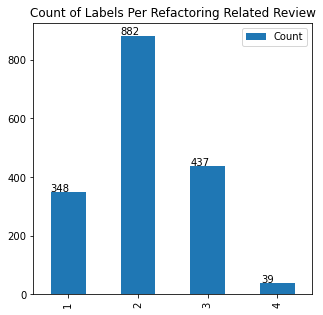

In [148]:
"""
Generate visual
"""
countplot = countDf.plot.bar(title="Count of Labels Per Refactoring Related Review",figsize=(5,5))
for p in countplot.patches:
    countplot.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
countplot

In [149]:
"""
Save visual
"""
countplot.get_figure().savefig('output/CategoriesPerExampleBarPlot.pdf')

In [150]:

"""
Clean description again, JIC
"""
pivotDf['description'] = pivotDf.apply(lambda row : row['description'].replace(str(row['subject']), ''), axis=1)
qualitativeExamineDf = pivotDf.copy()


In [151]:
"""
Utilize preprocess module in folder
"""

pivotDf= preprocess.pre_process(pivotDf)

In [152]:
"""
Regen concatenated column
"""
pivotDf['subjDescription']=pivotDf['subject']+' ' + pivotDf['description']

In [153]:
"""
Generate processed data 
for TF-IDF usage, post processing, 
for better insights from word cloud

"""
csvWriterr = pivotDf.copy()
csvWriterr['description'] = csvWriterr.apply(lambda row : row['description'].replace(str('refactor'), ''), axis=1)
csvWriterr['description'] = csvWriterr.apply(lambda row : row['description'].replace(str('refactoring'), ''), axis=1)
csvWriterr['subject'] = csvWriterr.apply(lambda row : row['subject'].replace(str('refactor'), ''), axis=1)
csvWriterr['subject'] = csvWriterr.apply(lambda row : row['subject'].replace(str('refactor'), ''), axis=1)
csvWriterr['subjDescription'] = csvWriterr['subject']+str(' ') + csvWriterr['description']







In [154]:
"""
write the csv
"""
csvWriterr.head()
csvWriterr.to_csv("../data/processed_data.csv",index=False)

In [155]:
"""

Train test split


"""

xtrain, xtest, ytrain , ytest = train_test_split(pivotDf[['subject','description','subjDescription']],
pivotDf[['integration','objective','quality','testing','refactoring']])

In [156]:
"""

Recreating DataFrames, necessary for fastText writer

"""
trainData = pd.concat([xtrain,ytrain],axis=1)
testData = pd.concat([xtest,ytest],axis=1)

In [157]:
"""

Method for creating the files from the raw data,
so it can work with the python API that just takes raw text input
"""

def writeFastTextFile(df: pd.DataFrame,xvar: string,trainTest: string):
    f = open("../data/"+xvar+trainTest+".txt", "w")
    for index,row in df.iterrows():
        if row['integration']==1:
            f.write("__label__integration ")
        if row['objective']==1:
            f.write("__label__objective ")
        if row['quality']==1:
            f.write("__label__quality ")
        if row['refactoring']==1:
            f.write("__label__refactoring ")
        if row['testing']==1:
            f.write("__label__testing ")
        f.write(" ")
        f.write(row[xvar])
        f.write(" \n")
    f.close()

            
        


In [158]:
"""

Bulk create test train files if needed

"""

def writeFastTextFiles(df: pd.DataFrame,type: string):

    writeFastTextFile(df,'subject',type)
    writeFastTextFile(df,'description',type)
    writeFastTextFile(df,'subjDescription',type)
   

In [159]:
"""

Writing the data

"""

writeFastTextFiles(trainData,"Train")
writeFastTextFiles(testData,"Test")

In [160]:
"""

Create the required FTA models with multi-class prediction specifications

"""

subjectModel = fasttext.train_supervised(input="../data/subjectTrain.txt",loss='ova',lr=0.05,epoch=25)
descriptionModel = fasttext.train_supervised(input="../data/descriptionTrain.txt",loss='ova',lr=0.05,epoch=25)
subjDescriptionModel = fasttext.train_supervised(input="../data/subjDescriptionTrain.txt",loss='ova',lr=0.05,epoch=25)


In [161]:
"""

Making copies of data

"""

subjDescriptionPredictions=trainData.copy()
separatePredictions=trainData.copy()



In [162]:

#Setting threshold to 0 outputs probabilities 
"""
wrapper method to get subject description combined model outputs
"""
def getSubjDescriptionPredictions(df: pd.DataFrame, subjDescriptionModel: fasttext):
     for index,row in df.iterrows():
        output = subjDescriptionModel.predict(row["subjDescription"], k=-1,threshold=0.00)
        for indexer,x in enumerate(output[0]):
            df.loc[index,"subjDescription"+output[0][indexer]] = output[1][indexer]


In [163]:
"""

Subject description concatenated model is here along 
with the test for f1 score baseline to gauge adequacy of approach

"""

subjDescriptionModel.test("../data/subjDescriptionTest.txt",k=-1,threshold=0.5)


(427, 0.7982646420824295, 0.8159645232815964)

In [164]:
"""

Subject model is here along with the test

"""

subjectModel.test("../data/subjectTest.txt",k=-1,threshold=0.5)



(427, 0.7601760176017601, 0.7660753880266076)

In [165]:
"""

Description model is here along with the test

"""

descriptionModel.test("../data/descriptionTest.txt",k=-1,threshold=0.5)



(427, 0.7905092592592593, 0.7572062084257206)

In [166]:
"""

Method for concatenating the
two separate outputs from the FTA
onto the inputted dataframe


"""

def separatePredictionMaker(df: pd.DataFrame, subjectModel: fasttext,descriptionModel: fasttext):
  
    for index,row in df.iterrows():
        output = subjectModel.predict(row["subject"], k=-1,threshold=0.00)
        for indexer,x in enumerate(output[0]):
            df.loc[index,"subject"+output[0][indexer]] = output[1][indexer]
    for index,row in df.iterrows():
        output = descriptionModel.predict(row["description"], k=-1,threshold=0.00)
        for indexer,x in enumerate(output[0]):
            df.loc[index,"description"+output[0][indexer]] = output[1][indexer]


In [167]:
"""
Create copy of DF for GBM model
"""

gbmDf= separatePredictions.copy()
gbmDfLengths = separatePredictions.copy()


separatePredictionMaker(gbmDf,subjectModel,descriptionModel)


In [168]:

"""
Create derived variable of lengths
"""
gbmDf=gbmDf.drop(['subjDescription'],axis=1)
gbmDfLengths = gbmDf.copy()
gbmDfLengths['subjLen']=gbmDfLengths.apply(lambda row : len(row['subject']), axis=1)
gbmDfLengths['descriptionLen']=gbmDfLengths.apply(lambda row : len(row['description']), axis=1)

In [169]:
"""
Train Length GBM classifier,
using OvA strategy on each label
"""
from sklearn.ensemble import GradientBoostingClassifier
xlistLen = gbmDfLengths.columns[7:]
ylistLen = gbmDfLengths.columns[2:7]
print(xlistLen)
classifierDictLengths= {}
for label in ylistLen:
   
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                    max_depth=2, random_state=0).fit(gbmDfLengths[xlistLen], gbmDfLengths[label])
  
    classifierDictLengths["{0}_classifierTrained".format(label)] = clf
   

                


Index(['subject__label__integration', 'subject__label__objective',
       'subject__label__quality', 'subject__label__refactoring',
       'subject__label__testing', 'description__label__objective',
       'description__label__quality', 'description__label__integration',
       'description__label__refactoring', 'description__label__testing',
       'subjLen', 'descriptionLen'],
      dtype='object', name='Category')


In [170]:
"""
Train regular gbm classifier, without length variables
"""
from sklearn.ensemble import GradientBoostingClassifier
xlist = gbmDf.columns[7:]
ylist = gbmDf.columns[2:7]

print(xlist)
classifierDict = {}
for label in ylist:
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                    max_depth=2, random_state=0).fit(gbmDf[xlist], gbmDf[label])
    
    classifierDict["{0}_classifierTrained".format(label)] = clf

                

Index(['subject__label__integration', 'subject__label__objective',
       'subject__label__quality', 'subject__label__refactoring',
       'subject__label__testing', 'description__label__objective',
       'description__label__quality', 'description__label__integration',
       'description__label__refactoring', 'description__label__testing'],
      dtype='object', name='Category')


In [171]:
"""
Test GBM Classifier,
make predictions
"""
testGBMdf = testData.copy()
separatePredictionMaker(testGBMdf,subjectModel,descriptionModel)
for key,model in classifierDict.items():
    testGBMdf["GBM"+key]=model.predict(testGBMdf[xlist])


In [172]:
"""

Test GBM Length Classifier,
make predictions

"""
testGBMdfLength = testData.copy()
separatePredictionMaker(testGBMdfLength,subjectModel,descriptionModel)
testGBMdfLength

testGBMdfLength['subjLen']=testGBMdfLength.apply(lambda row : len(row['subject']), axis=1)
testGBMdfLength['descriptionLen']=testGBMdfLength.apply(lambda row : len(row['description']), axis=1)

for key,model in classifierDictLengths.items():
    testGBMdfLength["GBM"+key]=model.predict(testGBMdfLength[xlistLen])

In [173]:
"""

Without Lengths,
see how many it is outputting to make sure it is outputting for each label and not learning
some weird static prediction 

"""
testing = testGBMdf.query("GBMtesting_classifierTrained == 1")
refactoring = testGBMdf.query("GBMrefactoring_classifierTrained == 1")
quality = testGBMdf.query("GBMquality_classifierTrained == 1")
objective = testGBMdf.query("GBMobjective_classifierTrained == 1")
integration = testGBMdf.query("GBMintegration_classifierTrained == 1")


In [174]:
print("Testing: "+str(testing.shape[0])+"\nRefactoring: "+str(refactoring.shape[0])
+"\nQuality: "+str(quality.shape[0])+"\nObjective: "+str(objective.shape[0])+"\nIntegration: "+str(integration.shape[0]))

Testing: 159
Refactoring: 12
Quality: 233
Objective: 359
Integration: 88


In [175]:
"""

GBM Test With Lengths
"""
testing = testGBMdfLength.query("GBMtesting_classifierTrained == 1")
refactoring = testGBMdfLength.query("GBMrefactoring_classifierTrained == 1")
quality = testGBMdfLength.query("GBMquality_classifierTrained == 1")
objective = testGBMdfLength.query("GBMobjective_classifierTrained == 1")
integration = testGBMdfLength.query("GBMintegration_classifierTrained == 1")


In [176]:
print("Testing: "+str(testing.shape[0])+"\nRefactoring: "+str(refactoring.shape[0])
+"\nQuality: "+str(quality.shape[0])+"\nObjective: "+str(objective.shape[0])+"\nIntegration: "+str(integration.shape[0]))

Testing: 160
Refactoring: 13
Quality: 231
Objective: 364
Integration: 89


In [177]:
testSeparatePredictionsDf = testData.copy()
separatePredictionMaker(testSeparatePredictionsDf,subjectModel,descriptionModel)

"""

Finished model averaging the two outputs 

"""
testSeparatePredictionsDf['avgIntegration'] = (testSeparatePredictionsDf['subject__label__integration']+testSeparatePredictionsDf['description__label__integration'])/2
testSeparatePredictionsDf['avgObjective'] = (testSeparatePredictionsDf['subject__label__objective']+testSeparatePredictionsDf['description__label__objective'])/2
testSeparatePredictionsDf['avgQuality'] = (testSeparatePredictionsDf['subject__label__quality']+testSeparatePredictionsDf['description__label__quality'])/2
testSeparatePredictionsDf['avgRefactoring'] = (testSeparatePredictionsDf['subject__label__refactoring']+testSeparatePredictionsDf['description__label__refactoring'])/2
testSeparatePredictionsDf['avgTesting'] = (testSeparatePredictionsDf['subject__label__testing']+testSeparatePredictionsDf['description__label__testing'])/2

"""

This requires a different testing method for 
precision and recall than their built in method

 """

'\n\nThis requires a different testing method for \nprecision and recall than their built in method\n\n '

In [178]:

def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [179]:
"""
Final Dfs
"""

subjDescriptionModel.test("../data/subjDescriptionTest.txt",k=-1,threshold=0.5)
#Final combined
testSeparatePredictionsDf
#Final separate w averages
testGBMdf
#Final gbm model preds
testGBMdfLength
#Final gbm model w lengths


Category,subject,description,subjDescription,integration,objective,quality,testing,refactoring,subject__label__objective,subject__label__quality,...,description__label__refactoring,description__label__integration,description__label__testing,subjLen,descriptionLen,GBMintegration_classifierTrained,GBMobjective_classifierTrained,GBMquality_classifierTrained,GBMtesting_classifierTrained,GBMrefactoring_classifierTrained
471,refactor clone workspace function use convert map to xml,refactor clone workspace function publishers py utilize convert map to xml refactor code function utilize convert map to xmls way detect valid type changeid ieffebfffecfef,refactor clone workspace function use convert map to xml refactor clone workspace function publishers py utilize convert map to xml refactor code function utilize convert map to xmls way detect valid type changeid ieffebfffecfef,0,1,1,0,0,0.737168,0.718604,...,0.177821,0.129413,0.014967,56,171,0,0,1,0,0
946,refactor tempurl functional test tryfinally,follow patch comment tim suggest implementation behavior code change implement suggestion detail changeid ifdafbdfccefffacf,refactor tempurl functional test tryfinally follow patch comment tim suggest implementation behavior code change implement suggestion detail changeid ifdafbdfccefffacf,0,0,1,1,0,0.843905,0.637041,...,0.085109,0.262852,0.044691,43,123,0,1,1,0,0
949,refactor test auth plugin config fixture,move logic fixture use large class hierarchies changeid ifddcceddfaabedfa,refactor test auth plugin config fixture move logic fixture use large class hierarchies changeid ifddcceddfaabedfa,0,1,1,1,0,0.859674,0.500010,...,0.058356,0.177821,0.132974,40,73,0,1,0,0,0
667,refactor l pop code pass mac ip info readably,refactor pop code pass mac ip device owner info readably changeid ifcbeeebbdfbbadbce closesbug,refactor l pop code pass mac ip info readably refactor pop code pass mac ip device owner info readably changeid ifcbeeebbdfbbadbce closesbug,0,0,1,0,0,0.798197,0.685959,...,0.009718,0.132974,0.212079,45,94,0,1,1,0,0
868,refactor runmirror readable,stab refactoring unspaghetti things changeid iecabfbffadaeefcce,refactor runmirror readable stab refactoring unspaghetti things changeid iecabfbffadaeefcce,0,0,1,0,0,0.977724,0.743178,...,0.250923,0.320831,0.109716,27,63,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,refactor create attribute statement idp method,create inner function build attribute avoid repeat command attribute changeid iedcabffccececabdcde,refactor create attribute statement idp method create inner function build attribute avoid repeat command attribute changeid iedcabffccececabdcde,0,1,1,0,0,0.919653,0.712242,...,0.038476,0.075868,0.029322,46,98,0,1,1,0,0
492,refactor common code tripleoci,commit refactors reusable piece tripleoci common function sh common vars bash preparation add ovb multinode support changeid iedffbddcbcadfacd,refactor common code tripleoci commit refactors reusable piece tripleoci common function sh common vars bash preparation add ovb multinode support changeid iedffbddcbcadfacd,0,0,1,0,1,0.760661,0.851963,...,0.206904,0.191943,0.148057,30,142,0,0,1,0,0
791,refactor placement fixtures,useful fixtures create ironic inventory change handy able access functional test patch doesnt change logic simply move fixtures file blueprint customresourceclassespike changeid icaffcffabcc,refactor placement fixtures useful fixtures create ironic inventory change handy able access functional test patch doesnt change logic simply move fixtures file blueprint customresourceclassespike changeid icaffcffabcc,0,1,1,1,0,0.437833,0.217348,...,0.017452,0.177821,0.777310,27,190,0,1,0,1,0
5,api call error handle refactoring,change refactors api service use fetch instead when reqwest combination improve error handle api request make action api call lighter changeid iadbbecabdccafeeebe,api call error handle refactoring change refactors api service use fetch instead when reqw

In [180]:
def scoreDataFrame(df: pd.DataFrame, predLabelList: list, truthLabelList: list  ):
    """
    Takes two sorted lists of predicted and 
    true labels and returns dataframe of prediction accuracy
    Lists must be in same order for comparison to work
    """
    
    for index,row in df.iterrows():
        for x in range(0,5):
            if df.loc[index,truthLabelList[x]]==1 and df.loc[index,predLabelList[x]]==1:
                df.loc[index,truthLabelList[x]+'Score']='TP'
            elif df.loc[index,truthLabelList[x]]==0 and df.loc[index,predLabelList[x]]==1:
                df.loc[index,truthLabelList[x]+'Score']='FP'
            elif df.loc[index,truthLabelList[x]]==1 and df.loc[index,predLabelList[x]]==0:
                df.loc[index,truthLabelList[x]+'Score']='FN'
            else:
                df.loc[index,truthLabelList[x]+'Score']='TN'
    labellist = []
    for x in truthLabelList:
        labellist.append(x+'Score')
    returnDf = df[labellist]
    return returnDf
    
            

In [181]:
"""
Testing the inner logic
from scoreDataFrame

"""


avgTruth = testSeparatePredictionsDf[['integration','objective','quality','testing','refactoring']]
avgPred = testSeparatePredictionsDf[['avgIntegration','avgObjective','avgQuality','avgTesting','avgRefactoring']]
truthList = ['integration','objective','quality','testing','refactoring']
predList = ['avgIntegration','avgObjective','avgQuality','avgTesting','avgRefactoring']
avgPredCat = avgPred.applymap(lambda x:1  if x>=0.5 else 0)

countTotalPositive = avgTruth.sum().sum()
print("Total True Positive Count: " +str(countTotalPositive))
countPredictedPositive = avgPredCat.sum().sum()
print("Total Predicted Positive Count: "+ str(countPredictedPositive))
concatTruthPred = pd.concat([avgTruth,avgPredCat],axis=1)
nameSet = ()
for index,row in concatTruthPred.iterrows():
    for x in range(0,5):
        if concatTruthPred.loc[index,truthList[x]]==1 and concatTruthPred.loc[index,predList[x]]==1:
            concatTruthPred.loc[index,truthList[x]+'Score']='TP'
        elif concatTruthPred.loc[index,truthList[x]]==0 and concatTruthPred.loc[index,predList[x]]==1:
            concatTruthPred.loc[index,truthList[x]+'Score']='FP'
        elif concatTruthPred.loc[index,truthList[x]]==1 and concatTruthPred.loc[index,predList[x]]==0:
            concatTruthPred.loc[index,truthList[x]+'Score']='FN'
        else:
            concatTruthPred.loc[index,truthList[x]+'Score']='TN'
        
        
concatTruthPred['qualityScore'].value_counts()
scoreDfAverageFt = concatTruthPred[['integrationScore','objectiveScore','qualityScore','testingScore','refactoringScore']]

            

Total True Positive Count: 902
Total Predicted Positive Count: 883


In [182]:
"""
Testing the scoreDataFrame method 
"""
testGBMdf
truth = ['integration','objective','quality','testing','refactoring']
pred = ['GBMintegration_classifierTrained','GBMobjective_classifierTrained','GBMquality_classifierTrained','GBMtesting_classifierTrained','GBMrefactoring_classifierTrained']
scoredGBMdf = scoreDataFrame(testGBMdf,pred,truth)

In [183]:
scoredGBMdf

Category,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
471,TN,FN,TP,TN,TN
946,TN,FP,TP,FN,TN
949,TN,TP,FN,FN,TN
667,TN,FP,TP,TN,TN
868,TN,TN,FN,TN,TN
...,...,...,...,...,...
374,TN,TP,TP,TN,TN
492,TN,TN,TP,TN,FN
791,TN,TP,FN,TP,TN
5,TP,TP,FP,TN,TN


In [184]:
"""
Testing again on different DF
"""
testGBMdfLength
truth = ['integration','objective','quality','testing','refactoring']
pred = ['GBMintegration_classifierTrained','GBMobjective_classifierTrained','GBMquality_classifierTrained','GBMtesting_classifierTrained','GBMrefactoring_classifierTrained']
scoredGBMdfLength = scoreDataFrame(testGBMdfLength,pred,truth)

In [185]:
scoredGBMdfLength

Category,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
471,TN,FN,TP,TN,TN
946,TN,FP,TP,FN,TN
949,TN,TP,FN,FN,TN
667,TN,FP,TP,TN,TN
868,TN,TN,FN,TN,TN
...,...,...,...,...,...
374,TN,TP,TP,TN,TN
492,TN,TN,TP,TN,FN
791,TN,TP,FN,TP,TN
5,TP,TP,FP,TN,TN


In [186]:
"""
Get trivial model predictions
"""
getSubjDescriptionPredictions(testData,subjDescriptionModel)


In [187]:
"""
Score trivial model predictions
"""
testData
predSingleLabels = testData[['subjDescription__label__testing',	'subjDescription__label__objective',	'subjDescription__label__quality',	'subjDescription__label__integration',	'subjDescription__label__refactoring']]
predSingleLabels = predSingleLabels.applymap(lambda x:1  if x>=0.5 else 0)
truth = ['integration','objective','quality','testing','refactoring']
pred = ['subjDescription__label__testing',	'subjDescription__label__objective',	'subjDescription__label__quality',	'subjDescription__label__integration',	'subjDescription__label__refactoring']
truthData = testData[truth]
singleClassifierDf= pd.concat([truthData,predSingleLabels],axis=1)
singleScores = scoreDataFrame(singleClassifierDf,pred,truth)


In [188]:
singleScores

Category,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
471,TN,TP,TP,TN,TN
946,TN,FP,TP,FN,TN
949,FP,TP,FN,FN,TN
667,TN,FP,TP,TN,TN
868,TN,TN,FN,TN,TN
...,...,...,...,...,...
374,TN,TP,TP,TN,TN
492,TN,FP,TP,TN,FN
791,FP,TP,TP,FN,TN
5,FN,TP,TN,FP,TN


In [189]:
"""
Rewriting for kfold validation on all 
"""

'\nRewriting for kfold validation on all \n'

In [190]:
"""
Custom scoring function to score on entire DF

"""

def scoring(df: pd.DataFrame):
    labels = ['integrationScore','objectiveScore','qualityScore','testingScore','refactoringScore']
    indexer = ['FN','FP','TN','TP']
    FN=0
    FP=0
    TN=0
    TP=0
    
    for label in labels:
        specific= df[label].value_counts()
        for val in indexer:
            if val not in specific.index:
                specific.loc[val]=0
        specific=specific.sort_index()
        FN=FN+specific[0]
        FP=FP+specific[1]
        TN=TN+specific[2]
        TP=TP+specific[3]
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = (2*precision*recall)/(precision+recall)
    return precision, recall, f1, FN, FP, TN, TP

In [191]:
individualLabels = ['integrationScore',	'objectiveScore',	'qualityScore',	'testingScore',	'refactoringScore']

In [192]:
gbmLengthValidated =pd.DataFrame(columns=['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP'])
zipper = ['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP']

for randState in range(0,10):
    """

Test GBM Length Classifier
10 Fold CrossValidation for Metric Stability

    """
    xtrain, xtest, ytrain , ytest = train_test_split(pivotDf[['subject','description','subjDescription']],
    pivotDf[['integration','objective','quality','testing','refactoring']],random_state=randState)
    trainData = pd.concat([xtrain,ytrain],axis=1)
    testData = pd.concat([xtest,ytest],axis=1)
    gbmDfLengths=trainData
    testGBMdfLength = testData

    writeFastTextFiles(trainData,"Train")
    subjectModel = fasttext.train_supervised(input="../data/subjectTrain.txt",loss='ova',lr=0.05,epoch=25)
    descriptionModel = fasttext.train_supervised(input="../data/descriptionTrain.txt",loss='ova',lr=0.05,epoch=25)
    separatePredictionMaker(gbmDfLengths,subjectModel,descriptionModel)

    gbmDfLengths['subjLen']=gbmDfLengths.apply(lambda row : len(row['subject']), axis=1)
    gbmDfLengths['descriptionLen']=gbmDfLengths.apply(lambda row : len(row['description']), axis=1)
    gbmDfLengths = gbmDfLengths.drop(['subjDescription'],axis=1)

    from sklearn.ensemble import GradientBoostingClassifier
    xlistLen = gbmDfLengths.columns[7:]
    ylistLen = gbmDfLengths.columns[2:7]
   
    classifierDictLengths= {}
    for label in ylistLen:
    
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                        max_depth=2, random_state=0).fit(gbmDfLengths[xlistLen], gbmDfLengths[label])
    
        classifierDictLengths["{0}_classifierTrained".format(label)] = clf
    separatePredictionMaker(testGBMdfLength,subjectModel,descriptionModel)

    testGBMdfLength['subjLen']=testGBMdfLength.apply(lambda row : len(row['subject']), axis=1)
    testGBMdfLength['descriptionLen']=testGBMdfLength.apply(lambda row : len(row['description']), axis=1)

    for key,model in classifierDictLengths.items():
        testGBMdfLength["GBM"+key]=model.predict(testGBMdfLength[xlistLen])
    truth = ['integration','objective','quality','testing','refactoring']
    pred = ['GBMintegration_classifierTrained','GBMobjective_classifierTrained','GBMquality_classifierTrained','GBMtesting_classifierTrained','GBMrefactoring_classifierTrained']
    scoredGBMdf = scoreDataFrame(testGBMdfLength,pred,truth)
    print("run "+str(randState)+" done")
    output = scoring(scoredGBMdf)
    output = dict(zip(zipper,output))
    gbmLengthValidated = gbmLengthValidated.append(output,ignore_index=True)

    if randState == 0: 
        gbmLengthValidatorExamination = pd.DataFrame()
        for label in individualLabels:
            gbmLengthValidatorExamination[label]=testGBMdfLength[label].value_counts().sort_index()
    else:
        for label in individualLabels:
            gbmLengthValidatorExamination[label]=testGBMdfLength[label].value_counts().sort_index()+gbmLengthValidatorExamination[label]

gbmLengthValidatorExamination=gbmLengthValidatorExamination/10


    

run 0 done
run 1 done
run 2 done
run 3 done
run 4 done
run 5 done
run 6 done
run 7 done
run 8 done
run 9 done


In [193]:
gbmLengthValidated

,precision,recall,f1,FN,FP,TN,TP
0,0.808858,0.779775,0.794050,196.0,164.0,1081.0,694.0
1,0.805399,0.784228,0.794673,197.0,173.0,1049.0,716.0
2,0.773933,0.770379,0.772152,200.0,196.0,1068.0,671.0
3,0.799324,0.793953,0.796629,184.0,178.0,1064.0,709.0
4,0.794279,0.796909,0.795592,184.0,187.0,1042.0,722.0
5,0.825359,0.752454,0.787222,227.0,146.0,1072.0,690.0
6,0.794960,0.778900,0.786848,197.0,179.0,1065.0,694.0
7,0.818599,0.781798,0.799776,199.0,158.0,1065.0,713.0
8,0.816575,0.815673,0.816124,167.0,166.0,1063.0,739.0
9,0.823991,0.820312,0.822148,161.0,157.0,1082.0,735.0


In [194]:
"""
Avg gbmLength Scores
"""
gbmLengthValidated.mean(axis=0)

precision       0.806128
recall          0.787438
f1              0.796521
FN            191.200000
FP            170.400000
TN           1065.100000
TP            708.300000
dtype: float64

In [195]:
"""
Std Deviation of Model
"""
gbmLengthValidated.std(axis=0)

precision     0.016019
recall        0.020272
f1            0.014282
FN           18.593906
FP           15.123198
TN           12.440525
TP           21.239638
dtype: float64

In [196]:
gbmLengthValidatorExamination

,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
FN,43.0,27.1,52.5,36.8,31.8
FP,16.0,53.9,74.2,17.4,8.9
TN,299.3,41.9,125.7,221.8,376.4
TP,68.7,304.1,174.6,151.0,9.9


In [197]:
gbmValidated =pd.DataFrame(columns=['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP'])
zipper = ['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP']


for randState in range(0,10):
    """

Test GBM Classifier
10 fold validation

    """
    xtrain, xtest, ytrain , ytest = train_test_split(pivotDf[['subject','description','subjDescription']],
    pivotDf[['integration','objective','quality','testing','refactoring']],random_state=randState)
    trainData = pd.concat([xtrain,ytrain],axis=1)
    testData = pd.concat([xtest,ytest],axis=1)
    gbmDf=trainData
    testGBMdf = testData

    writeFastTextFiles(trainData,"Train")
    
    subjectModel = fasttext.train_supervised(input="../data/subjectTrain.txt",loss='ova',lr=0.05,epoch=25)
    descriptionModel = fasttext.train_supervised(input="../data/descriptionTrain.txt",loss='ova',lr=0.05,epoch=25)
    separatePredictionMaker(gbmDf,subjectModel,descriptionModel)

   
    gbmDf = gbmDf.drop(['subjDescription'],axis=1)

    from sklearn.ensemble import GradientBoostingClassifier
    xlistLen = gbmDf.columns[7:]
    ylistLen = gbmDf.columns[2:7]
   
    classifierDict= {}
    for label in ylistLen:
    
        clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                        max_depth=2, random_state=0).fit(gbmDf[xlistLen], gbmDf[label])
    
        classifierDict["{0}_classifierTrained".format(label)] = clf
    separatePredictionMaker(testGBMdf,subjectModel,descriptionModel)

    for key,model in classifierDict.items():
        testGBMdf["GBM"+key]=model.predict(testGBMdf[xlistLen])
    truth = ['integration','objective','quality','testing','refactoring']
    pred = ['GBMintegration_classifierTrained','GBMobjective_classifierTrained','GBMquality_classifierTrained','GBMtesting_classifierTrained','GBMrefactoring_classifierTrained']
    scoredGBMdfNoLen = scoreDataFrame(testGBMdf,pred,truth)
    print("run "+str(randState)+" done")
    output = scoring(scoredGBMdfNoLen)
    output = dict(zip(zipper,output))
    gbmValidated = gbmValidated.append(output,ignore_index=True)

    if randState == 0: 
        gbmValidatorExamination = pd.DataFrame()
        for label in individualLabels:
            gbmValidatorExamination[label]=testGBMdf[label].value_counts().sort_index()
    else:
        for label in individualLabels:
            gbmValidatorExamination[label]=testGBMdf[label].value_counts().sort_index()+gbmValidatorExamination[label]

gbmValidatorExamination=gbmValidatorExamination/10

run 0 done
run 1 done
run 2 done
run 3 done
run 4 done
run 5 done
run 6 done
run 7 done
run 8 done
run 9 done


In [198]:
gbmValidated.mean()

precision       0.806688
recall          0.781924
f1              0.793944
FN            196.200000
FP            168.700000
TN           1066.800000
TP            703.300000
dtype: float64

In [199]:
gbmValidated.std()

precision     0.016817
recall        0.018837
f1            0.013165
FN           17.806366
FP           16.892141
TN           15.295606
TP           18.553526
dtype: float64

In [200]:
gbmValidatorExamination

,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
FN,42.5,30.0,54.6,38.1,31.0
FP,16.0,52.2,73.9,17.4,9.2
TN,299.3,43.6,126.0,221.8,376.1
TP,69.2,301.2,172.5,149.7,10.7


In [201]:
combinedValidator =pd.DataFrame(columns=['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP'])
zipper = ['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP']


for randState in range(0,10):
    """

Combined Model Validator
10 fold validation

    """
    xtrain, xtest, ytrain , ytest = train_test_split(pivotDf[['subject','description','subjDescription']],
    pivotDf[['integration','objective','quality','testing','refactoring']],random_state=randState)
    trainData = pd.concat([xtrain,ytrain],axis=1)
    testData = pd.concat([xtest,ytest],axis=1)
    writeFastTextFiles(trainData,"Train")
   
    
    subjDescriptionModel = fasttext.train_supervised(input="../data/subjDescriptionTrain.txt",loss='ova',lr=0.05,epoch=25)
    getSubjDescriptionPredictions(testData,subjDescriptionModel)

    predSingleLabels = testData[['subjDescription__label__testing',	'subjDescription__label__objective',	'subjDescription__label__quality',	'subjDescription__label__integration',	'subjDescription__label__refactoring']]
    predSingleLabels = predSingleLabels.applymap(lambda x:1  if x>=0.5 else 0)
    truth = ['integration','objective','quality','testing','refactoring']
    pred = ['subjDescription__label__integration',	'subjDescription__label__objective',	'subjDescription__label__quality',	'subjDescription__label__testing',	'subjDescription__label__refactoring']
    truthData = testData[truth]
    singleClassifierDf= pd.concat([truthData,predSingleLabels],axis=1)
    singleScores = scoreDataFrame(singleClassifierDf,pred,truth)
    print("run "+str(randState)+" done")
    output = scoring(singleScores)
    output = dict(zip(zipper,output))
    combinedValidator = combinedValidator.append(output,ignore_index=True)

    if randState == 0: 
        combinedValidatorExamination = pd.DataFrame()
        for label in individualLabels:
            combinedValidatorExamination[label]=singleClassifierDf[label].value_counts().sort_index()
    else:
        for label in individualLabels:
            df = singleClassifierDf[label].value_counts().sort_index()
            indexer = ['FN','FP','TN','TP']

            for val in indexer:
                if val not in df.index:
                    df.loc[val]=0
            combinedValidatorExamination[label]=df+combinedValidatorExamination[label]
            
combinedValidatorExamination=combinedValidatorExamination/10


    

run 0 done
run 1 done
run 2 done
run 3 done
run 4 done
run 5 done
run 6 done
run 7 done
run 8 done
run 9 done


In [202]:
subjDescriptionModel.test("../data/subjDescriptionTest.txt",k=-1,threshold=0.5)


(427, 0.8315450643776824, 0.8592017738359202)

In [203]:
combinedValidator.mean()

precision       0.803192
recall          0.812694
f1              0.807840
FN            168.500000
FP            179.100000
TN           1056.400000
TP            731.000000
dtype: float64

In [204]:
combinedValidator.std()

precision     0.014610
recall        0.016550
f1            0.013300
FN           15.429049
FP           13.353734
TN           11.635196
TP           17.944358
dtype: float64

In [205]:
combinedValidatorExamination

,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
FN,49.4,18.6,40.7,28.1,31.7
FP,8.8,59.2,89.2,16.6,5.3
TN,306.5,36.6,110.7,222.6,380.0
TP,62.3,312.6,186.4,159.7,10.0


In [206]:
averagedValidator =pd.DataFrame(columns=['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP'])
zipper = ['precision', 'recall', 'f1', 'FN', 'FP', 'TN', 'TP']


for randState in range(0,10):
    """

Averaged Model Validator
10 fold validation
    """
    xtrain, xtest, ytrain , ytest = train_test_split(pivotDf[['subject','description','subjDescription']],
    pivotDf[['integration','objective','quality','testing','refactoring']],random_state=randState)
    trainData = pd.concat([xtrain,ytrain],axis=1)
    testData = pd.concat([xtest,ytest],axis=1)
    writeFastTextFiles(trainData,"Train")
   
    subjectModel = fasttext.train_supervised(input="../data/subjectTrain.txt",loss='ova',lr=0.05,epoch=25)
    descriptionModel = fasttext.train_supervised(input="../data/descriptionTrain.txt",loss='ova',lr=0.05,epoch=25)
    separatePredictionMaker(testData,subjectModel,descriptionModel)

    testData['avgIntegration'] = (testData['subject__label__integration']+testData['description__label__integration'])/2
    testData['avgObjective'] = (testData['subject__label__objective']+testData['description__label__objective'])/2
    testData['avgQuality'] = (testData['subject__label__quality']+testData['description__label__quality'])/2
    testData['avgRefactoring'] = (testData['subject__label__refactoring']+testData['description__label__refactoring'])/2
    testData['avgTesting'] = (testData['subject__label__testing']+testData['description__label__testing'])/2

    

    predAvgLabels = testData[['avgIntegration',	'avgObjective',	'avgQuality',	'avgRefactoring',	'avgTesting']]
    predAvgLabels = predAvgLabels.applymap(lambda x:1  if x>=0.5 else 0)
    truth = ['integration','objective','quality','testing','refactoring']
    pred = ['avgIntegration',	'avgObjective',	'avgQuality',	'avgTesting',	'avgRefactoring']
    truthData = testData[truth]
    avgClassifierDf= pd.concat([truthData,predAvgLabels],axis=1)
    singleScores = scoreDataFrame(avgClassifierDf,pred,truth)
    print("run "+str(randState)+" done")
    output = scoring(singleScores)
    output = dict(zip(zipper,output))
    averagedValidator = averagedValidator.append(output,ignore_index=True)

    if randState == 0: 
        avgValidatorExamination = pd.DataFrame()
        for label in individualLabels:
            avgValidatorExamination[label]=avgClassifierDf[label].value_counts().sort_index()
    else:
        for label in individualLabels:
            df = avgClassifierDf[label].value_counts().sort_index()

            indexer = ['FN','FP','TN','TP']
            for val in indexer:
                if val not in df.index:
                    df.loc[val]=0
            avgValidatorExamination[label]=df+avgValidatorExamination[label]
            
avgValidatorExamination=avgValidatorExamination/10

run 0 done
run 1 done
run 2 done
run 3 done
run 4 done
run 5 done
run 6 done
run 7 done
run 8 done
run 9 done


In [207]:
averagedValidator.mean()

precision       0.796685
recall          0.796786
f1              0.796569
FN            182.800000
FP            183.100000
TN           1052.400000
TP            716.700000
dtype: float64

In [208]:
averagedValidator.std()

precision     0.020324
recall        0.017113
f1            0.014287
FN           15.809983
FP           20.283819
TN           13.167300
TP           18.577465
dtype: float64

In [209]:
avgValidatorExamination

,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
FN,61.3,9.9,37.2,37.4,37.0
FP,6.2,71.7,91.5,13.3,NaN
TN,309.1,24.1,108.4,225.9,384.9
TP,50.4,321.3,189.9,150.4,4.7


# Beginning of Qualitative Examination

This consists of creating DFs specifically where there are FN or FPs of each category,
then directly viewing an example for further qualitative examination.


In [210]:
singleClassifierDf
qualitativeExamineDf['subjDescription'] = qualitativeExamineDf['subject']+qualitativeExamineDf['description']
finalExamDf = qualitativeExamineDf['subjDescription']
integrationFN = singleClassifierDf.query("integrationScore == 'FN'")
integrationFP = singleClassifierDf.query("integrationScore == 'FP'")
objectiveFN = singleClassifierDf.query("objectiveScore == 'FN'")
objectiveFP = singleClassifierDf.query("objectiveScore == 'FP'")
qualityFN = singleClassifierDf.query("qualityScore == 'FN'")
qualityFP = singleClassifierDf.query("qualityScore == 'FP'")
testingFN = singleClassifierDf.query("testingScore == 'FN'")
testingFP = singleClassifierDf.query("testingScore == 'FP'")
refactoringFN = singleClassifierDf.query("refactoringScore == 'FN'")
refactoringFP = singleClassifierDf.query("refactoringScore == 'FP'")

In [211]:
integrationFN

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
1606,1,1,0,0,0,1,1,0,0,0,FN,TP,TN,FP,TN
2,1,1,0,1,0,1,1,1,0,0,FN,TP,FP,TP,TN
277,1,1,0,0,0,0,1,1,0,0,FN,TP,FP,TN,TN
531,1,1,1,1,0,1,1,0,0,0,FN,TP,FN,TP,TN
807,1,1,0,0,0,0,1,0,0,0,FN,TP,TN,TN,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,1,1,1,0,0,1,0,0,0,FN,TP,FN,FN,TN
1601,1,1,0,0,0,0,1,1,0,0,FN,TP,FP,TN,TN
1431,1,1,0,0,0,1,1,1,0,0,FN,TP,FP,FP,TN
1432,1,1,0,0,0,0,1,1,0,0,FN,TP,FP,TN,TN


In [212]:
finalExamDf.loc[[1606]]

1606    refactor image functional testsrefactor image function tests  following the pattern established in commit 09b783ad3e5051564bf6321feace3b65739febbf, create a common module that sets the API version we plan to use for the tests.  Change-Id: I1429d61f6f9eb14f20058d749088b58203b1e0dc
Name: subjDescription, dtype: object

In [213]:
integrationFP

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
1182,0,1,0,1,0,0,1,1,1,0,FP,TP,FP,FN,TN
874,0,1,0,1,0,1,1,0,1,0,FP,TP,TN,TP,TN
362,0,1,1,1,0,0,1,1,1,0,FP,TP,TP,FN,TN
74,0,1,0,1,0,0,1,0,1,0,FP,TP,TN,FN,TN
81,0,1,0,1,0,1,1,0,1,0,FP,TP,TN,TP,TN
442,0,1,1,0,0,0,1,1,1,0,FP,TP,TP,TN,TN
426,0,1,0,0,0,0,1,0,1,0,FP,TP,TN,TN,TN
1273,0,0,1,0,0,0,1,0,1,0,FP,FP,FN,TN,TN


In [214]:
finalExamDf.loc[[1182]]

1182    Refactored access to RequestContext.  RequestContext is passed all over the internal api and it's only used in few places in oslo code and some ironic drivers. I've refactored access to context to make it directly available using: ironic.common.context.get_current_context() function This allows us to remove context parameter from everywhere.  Review process suggestions: 1) ironic/common/context.py - This file provides basic functionality and you need to check it to get the main idea 2) ironic/api/hooks.py - This is a entry point that publishes context for all public API requests 3) ironic/conductor/manager.py - Entry point that publishes context for internal tasks run by scheduler 4) Review all other files. In most files we just remove context from parameters. In test files we fix mock assertions and setUp to publish context manually  Change-Id: Ibe4ac3dcef430cdafca3d4785ae5fc45fd4b7751
Name: subjDescription, dtype: object

In [215]:
xtest.loc[[1606]]

Category,subject,description,subjDescription
1606,refactor image functional test,refactor image function test follow pattern establish commit badebffeacebfebbf create common module set api version plan use test changeid idffebfdbbedc,refactor image functional test refactor image function test follow pattern establish commit badebffeacebfebbf create common module set api version plan use test changeid idffebfdbbedc


In [216]:
objectiveFN

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
1102,0,1,1,1,0,0,0,1,0,0,TN,FN,TP,FN,TN
1101,0,1,1,0,0,0,0,1,0,0,TN,FN,TP,TN,TN
1136,0,1,1,0,0,0,0,0,0,0,TN,FN,FN,TN,TN
1351,1,1,0,0,0,0,0,0,1,0,TP,FN,TN,TN,TN
97,0,1,0,0,0,0,0,1,0,0,TN,FN,FP,TN,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,1,1,0,1,0,1,0,0,0,0,FN,FN,TN,TP,TN
1400,0,1,0,0,1,0,0,0,0,1,TN,FN,TN,TN,TP
674,0,1,0,0,0,0,0,0,0,0,TN,FN,TN,TN,TN
1244,0,1,1,0,0,0,0,0,0,0,TN,FN,FN,TN,TN


In [217]:
finalExamDf.loc[[1101]]

1101    Refactor useful nova functions for re-use.  Refactor handy nova functions out of Instance and into a helper module. This allows alternate compute implementations to use this functionality without having to subclass.  Change-Id: I529e2d1324981de7336264b5c697f1944668d013
Name: subjDescription, dtype: object

In [218]:
objectiveFP

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
1630,0,0,1,0,0,0,1,1,0,0,TN,FP,TP,TN,TN
829,0,0,0,1,0,1,1,0,0,0,TN,FP,TN,TP,TN
1420,0,0,1,0,0,0,1,1,0,0,TN,FP,TP,TN,TN
877,0,0,1,1,0,1,1,0,0,0,TN,FP,FN,TP,TN
229,0,0,1,1,0,1,1,1,0,0,TN,FP,TP,TP,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,0,0,1,1,0,1,1,1,0,0,TN,FP,TP,TP,TN
753,1,0,1,0,0,0,1,0,1,0,TP,FP,FN,TN,TN
1273,0,0,1,0,0,0,1,0,1,0,FP,FP,FN,TN,TN
1303,0,0,1,0,0,0,1,1,0,0,TN,FP,TP,TN,TN


In [219]:
finalExamDf.loc[[1630]]

1630    refactor the check_state function in orchestrator  _check_state of Orchestrator and check_state of Worker are the same. this patch refactor this for deleting the _check_state of Orchestrator and changing some logical in the code.  Change-Id: I4fa99e40d26d813399dbfe875f4bc9e4e5af9dcd
Name: subjDescription, dtype: object

In [220]:
qualityFN

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
868,0,0,1,0,0,0,0,0,0,0,TN,TN,FN,TN,TN
1311,0,0,1,0,0,1,0,0,0,0,TN,TN,FN,FP,TN
924,1,1,1,1,0,1,1,0,1,0,TP,TP,FN,TP,TN
1538,1,1,1,0,0,0,1,0,1,0,TP,TP,FN,TN,TN
877,0,0,1,1,0,1,1,0,0,0,TN,FP,FN,TP,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1,0,1,0,0,0,1,0,1,0,TP,FP,FN,TN,TN
1038,0,1,1,1,0,1,1,0,0,0,TN,TP,FN,TP,TN
1273,0,0,1,0,0,0,1,0,1,0,FP,FP,FN,TN,TN
1292,0,1,1,1,0,1,1,0,0,0,TN,TP,FN,TP,TN


In [221]:
finalExamDf.loc[[868]]

868    Refactor run-mirror to make it readable  First stab at refactoring to unspaghetti things.  Change-Id: I1e70c14a4b9f04bf3fad9aeef98c9ce230469019
Name: subjDescription, dtype: object

In [222]:
qualityFP

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
1530,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
1562,0,1,0,0,0,0,1,1,0,0,TN,TP,FP,TN,TN
1446,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
332,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
2,1,1,0,1,0,1,1,1,0,0,FN,TP,FP,TP,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
1200,0,1,0,1,0,0,1,1,0,0,TN,TP,FP,FN,TN
1676,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
1048,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN


In [223]:
finalExamDf.loc[[1530]]

1530    [WIP] Remove code from Selenium Test Refactor  This change would further refactor the Selenium Tests in order to move boilerplate code to separate file.  Change-Id: I61071d19ec89f22d50417c80ceccb1be58f89e70
Name: subjDescription, dtype: object

In [224]:
qualityFN

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
868,0,0,1,0,0,0,0,0,0,0,TN,TN,FN,TN,TN
1311,0,0,1,0,0,1,0,0,0,0,TN,TN,FN,FP,TN
924,1,1,1,1,0,1,1,0,1,0,TP,TP,FN,TP,TN
1538,1,1,1,0,0,0,1,0,1,0,TP,TP,FN,TN,TN
877,0,0,1,1,0,1,1,0,0,0,TN,FP,FN,TP,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,1,0,1,0,0,0,1,0,1,0,TP,FP,FN,TN,TN
1038,0,1,1,1,0,1,1,0,0,0,TN,TP,FN,TP,TN
1273,0,0,1,0,0,0,1,0,1,0,FP,FP,FN,TN,TN
1292,0,1,1,1,0,1,1,0,0,0,TN,TP,FN,TP,TN


In [225]:
finalExamDf.loc[[868]]

868    Refactor run-mirror to make it readable  First stab at refactoring to unspaghetti things.  Change-Id: I1e70c14a4b9f04bf3fad9aeef98c9ce230469019
Name: subjDescription, dtype: object

In [226]:
qualityFP

Category,integration,objective,quality,testing,refactoring,subjDescription__label__testing,subjDescription__label__objective,subjDescription__label__quality,subjDescription__label__integration,subjDescription__label__refactoring,integrationScore,objectiveScore,qualityScore,testingScore,refactoringScore
1530,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
1562,0,1,0,0,0,0,1,1,0,0,TN,TP,FP,TN,TN
1446,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
332,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
2,1,1,0,1,0,1,1,1,0,0,FN,TP,FP,TP,TN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1206,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
1200,0,1,0,1,0,0,1,1,0,0,TN,TP,FP,FN,TN
1676,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN
1048,0,1,0,1,0,1,1,1,0,0,TN,TP,FP,TP,TN


In [227]:
finalExamDf.loc[[1530]]

1530    [WIP] Remove code from Selenium Test Refactor  This change would further refactor the Selenium Tests in order to move boilerplate code to separate file.  Change-Id: I61071d19ec89f22d50417c80ceccb1be58f89e70
Name: subjDescription, dtype: object